In [1]:
%pip install 'tensorflow[and-cuda]' spacy scikit-learn pandas matplotlib transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.metrics import Precision, Recall, AUC
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras.utils import to_categorical
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tokenizers import BertWordPieceTokenizer
import transformers
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
import math
import warnings
warnings.filterwarnings('ignore')



2024-01-31 11:53:28.655445: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 11:53:28.689495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 11:53:28.689532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 11:53:28.690687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 11:53:28.696954: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-31 11:53:32.786099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 11:53:32.827719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 11:53:32.827929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
data_test = pd.read_csv('dados_teste.txt', sep=';', header=None)
data_train = pd.read_csv('dados_treino.txt', sep=';', header=None)
data_test.columns = ['text', 'label']
data_train.columns = ['text', 'label']
data_test.head()

,text,label
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [6]:
print('shape train data: {}\nshape test data: {}'.format(
    data_train.shape, data_test.shape))

shape train data: (16000, 2)
shape test data: (2000, 2)


In [7]:
data_train['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [8]:
data_test['label'].value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [9]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [10]:
nlp = spacy.load('en_core_web_md')


def process_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip()
              for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [11]:
data_train['processed_text'] = data_train['text'].apply(process_text)
data_test['processed_text'] = data_test['text'].apply(process_text)

In [12]:
print(data_test.head())
print(data_train.head())

                                                text    label  \
0  i feel like my only role now would be to tear ...  sadness   
1  i feel just bcoz a fight we get mad to each ot...    anger   
2  i feel like reds and purples are just so rich ...      joy   
3  im not sure the feeling of loss will ever go a...  sadness   
4  i feel like ive gotten to know many of you thr...      joy   

                                      processed_text  
0      feel like role tear sail pessimism discontent  
1  feel bcoz fight mad n u wanna publicity n let ...  
2             feel like red purple rich kind perfect  
3  m sure feeling loss away dull sweet feeling no...  
4  feel like ve get know comment email m apprecia...  
                                                text    label  \
0  i am feeling completely overwhelmed i have two...     fear   
1    i have the feeling she was amused and delighted      joy   
2  i was able to help chai lifeline with your sup...      joy   
3  i already feel l

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train['processed_text'])
vocab_size = len(tokenizer.word_index) + 1
print('vocab size: {}'.format(vocab_size))


vocab size: 11897


In [14]:
maxlen = 100
embed_len = 100

In [15]:
sequence_train = tokenizer.texts_to_sequences(data_train['processed_text'])
sequence_test = tokenizer.texts_to_sequences(data_test['processed_text'])
pad_sequences_train = pad_sequences(sequence_train, maxlen=maxlen, truncating='post')
pad_sequences_test = pad_sequences(sequence_test, maxlen=maxlen, truncating='post')

In [16]:
model = Sequential([
    Embedding(vocab_size, embed_len, input_length=maxlen),
    Bidirectional(LSTM(100, return_sequences=True)),
    Bidirectional(LSTM(50)),
    Dropout(0.5),
    Dense(64, activation='leaky_relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(), Precision(), Recall(), 'accuracy'])
model.summary()

2024-01-31 11:55:30.203571: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 11:55:30.203840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 11:55:30.203933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189700   
                                                                 
 bidirectional (Bidirection  (None, 100, 200)          160800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [17]:
encoder = LabelEncoder()
encoder.fit(data_train['label'])
y_train = encoder.transform(data_train['label'])
y_test = encoder.transform(data_test['label'])
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)


In [18]:
model.layers[-1].bias.assign(compute_class_weight('balanced', classes= np.unique(y_train),y= y_train))

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [19]:
history = model.fit(pad_sequences_train, y_train_enc, 
          epochs=100, batch_size=64, 
          validation_split=0.2, 
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True), LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)],
          )

Epoch 1/100


2024-01-31 11:55:36.974675: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-31 11:55:38.762473: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1808273910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 11:55:38.762497: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-31 11:55:38.767578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706712938.849835   12527 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 22s 72ms/step - loss: 0.6147 - auc: 0.5975 - precision: 0.2452 - recall: 0.1296 - accuracy: 0.2386 - val_loss: 0.4082 - val_auc: 0.7166 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3262 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 5s 26ms/step - loss: 0.4677 - auc: 0.6818 - precision: 0.3209 - recall: 0.0984 - accuracy: 0.2923 - val_loss: 0.4081 - val_auc: 0.7282 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3262 - lr: 9.0000e-04
Epoch 3/100
200/200 [==============================] - 4s 22ms/step - loss: 0.4418 - auc: 0.7175 - precision: 0.4057 - recall: 0.1147 - accuracy: 0.3220 - val_loss: 0.3835 - val_auc: 0.7919 - val_precision: 0.6796 - val_recall: 0.1200 - val_accuracy: 0.3516 - lr: 8.1000e-04
Epoch 4/100
200/200 [==============================] - 3s 17ms/step - loss: 0.3877 - auc: 0.7983 - precision: 0.5412 - recall: 0.2438 - accuracy: 0.3903 - val_loss: 0.3341 - 

<Axes: title={'center': 'Loss'}>

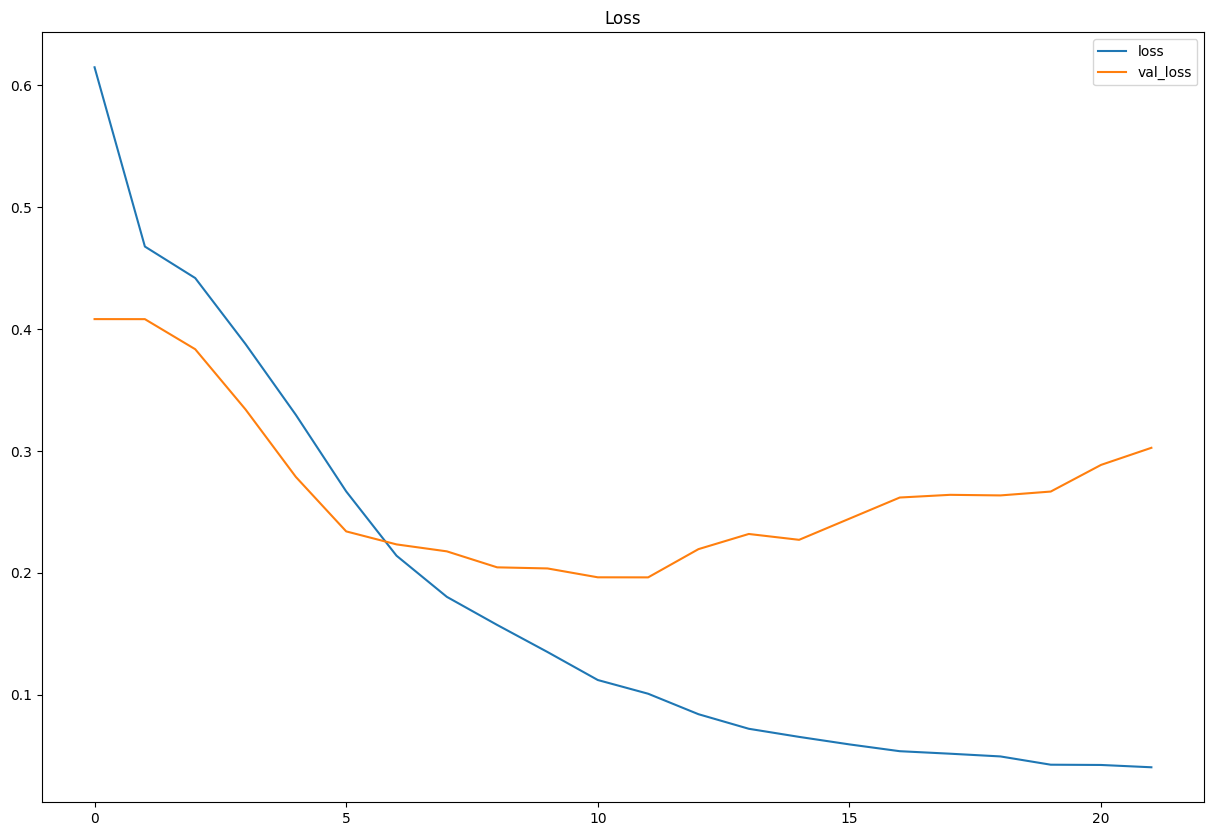

In [20]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(15, 10), title='Loss', legend=True)

In [26]:
print(classification_report(data_test['label'], encoder.inverse_transform(model.predict(pad_sequences_test).argmax(axis=1))))

63/63 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       anger       0.74      0.86      0.80       275
        fear       0.86      0.74      0.79       224
         joy       0.92      0.90      0.91       695
        love       0.61      0.61      0.61       159
     sadness       0.93      0.90      0.91       581
    surprise       0.55      0.70      0.62        66

    accuracy                           0.85      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.85      0.85      0.85      2000

